# Setup to play the unlabeled game, randomly choosing a vertex to fire each time

In [181]:
import random
import copy

def getInstar(k,m):
    N = k*m
    instar = []
    for i in range(k):
        branch = []
        branch.append(N)
        for j in range(m+1):
            branch.append(0)
        instar.append(branch)
    return instar

def getKM(graph):
    k = len(graph)
    m = len(graph[0])-2
    return (k,m)

def getFirable(graph):
    km = getKM(graph)
    k = km[0]
    m = km[1]
    firable = []
    if graph[0][0] >= k:
        firable.append([0,0])
    for i in range(k):
        for j in range(1,m+2):
            if graph[i][j] >= 2:
                firable.append([i,j])
    return firable

def fireVertex(graph,i,j):
    km = getKM(graph)
    k = km[0]
    m = km[1]
    new_graph = copy.deepcopy(graph)
    # if the center is the one firing, fire k chips to the level 1 vertices
    if j == 0:
        for branch in new_graph:
            branch[0] += -1*k
            branch[1] += 1
    # otherwise if level 1 vertex fires, make sure to update the center for all branches
    elif j == 1:
        for branch in new_graph:
            branch[0] += 1
        new_graph[i][j] += -2
        new_graph[i][j+1] += 1
    # otherwise fire normal
    else:
        new_graph[i][j] += -2
        new_graph[i][j-1] += 1
        new_graph[i][j+1] += 1
    return new_graph

def playGame(k,m):
    N = k*m
    graph = getInstar(k,m)

    fired = True
    listFiredVertices = []
    
    while fired == True:
        fired = False
        firableVertices = getFirable(graph)
        if len(firableVertices) != 0:
            fired = True
            firedVertex = random.sample(firableVertices, 1)
            # print(f"fired: {firedVertex[0]}")
            listFiredVertices.append(firedVertex[0])
            graph = fireVertex(graph,firedVertex[0][0],firedVertex[0][1])

    return (graph, listFiredVertices)

# EXAMPLES

# instar33 = getInstar(3,3)
# print(getKM(instar33))
# print(instar33)
# print(getFirable(instar33))
# print(fireVertex(instar33,0,0))

stable = playGame(3,2)
print(f"final graph: {stable[0]}")
print(f"vertices fired: {stable[1]}")

final graph: [[0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0]]
vertices fired: [[0, 0], [0, 0], [2, 1], [0, 1], [1, 1], [0, 0]]


# Code to get a graph of reachable configurations, with edges labeled by which vertex fires (with vertices of the form [i,j] where i is the branch and j is the vertex; j=0 is the center)

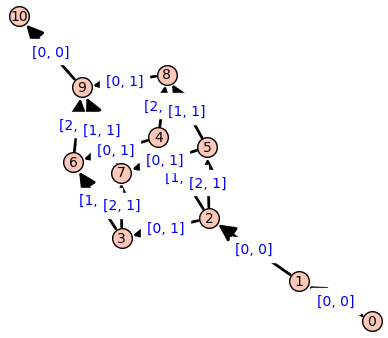

In [182]:
def generate_reachable_configs(config):
    reachableConfigs = [config]
    new_configs_found = True
    while new_configs_found:
        new_configs_found = False
        for current_config in reachableConfigs[:]:
            firable = getFirable(current_config)
            # print(f"firable: {firable}")
            for vertex in firable:
                new_config = fireVertex(current_config,vertex[0],vertex[1])
                # print(reachableConfigs)
                # print(new_config)
                # if new_config is not None:
                #     print("new config is not none")
                # if new_config not in reachableConfigs:
                #     print("new config not in reachable configs")
                if new_config is not None and new_config not in reachableConfigs:
                    reachableConfigs.append(new_config)
                    new_configs_found = True
                    # print("new configs found")
    return reachableConfigs

def genEdges(config):
    reachableConfigs = generate_reachable_configs(config)
    numVertices = len(reachableConfigs)
    edges = []
    edgeDicts = []
    for i in range(numVertices):
        reached = reachableConfigs[i]
        check_firings = getFirable(reached)
        for firable in check_firings:
            firedConfig = fireVertex(reached,firable[0],firable[1])
            if firedConfig in reachableConfigs and [i,reachableConfigs.index(firedConfig)] not in edges:
                edges.append([i,reachableConfigs.index(firedConfig)])
                edgeDicts.append({'edge':[i,reachableConfigs.index(firedConfig)],'label':firable})
            else:
                pass
    return (edges,edgeDicts)

# PROMPT: in sagemath, i have a list of dictionaries with keys 'edge' and 'label'. I want to find the dictionary in the list which has the value 'edge' set to A, and then return the value of that dictionary's 'label'
# Function to find the dictionary with edge 'A' and return its label
def find_label_by_edge(list_of_dicts, edge_value):
    for dictionary in list_of_dicts:
        if dictionary['edge'] == edge_value:
            return dictionary['label']
    return None  # Return None if no matching edge is found

def getDigraphPoset(config,show):
    generate_reachable_configs(config)
    edgePair = genEdges(config)
    edges = edgePair[0]
    edgeDicts = edgePair[1]
    graph = DiGraph(edges)
    poset = Poset(graph)
    # poset.show()
    for edge in edges:
        label = find_label_by_edge(edgeDicts, edge)
        graph.set_edge_label(edge[0],edge[1],label)
    if show == True:
        graph.show(edge_labels=True)
    return (graph,poset)

# EXAMPLE
instar33 = getInstar(3,2)
show_graph = True
pair = getDigraphPoset(instar33,show_graph)
graph = pair[0]
poset = pair[1]

# code to get the firing sequences

In [183]:
def getChains(graph,poset):
    chains = []
    for maxChain in poset.maximal_chains():
        # print(maxChain)
        newChain = []
        for i in range(len(maxChain)-1):
            # edge = [maxChain[i],maxChain[i+1]]
            # print(edge)
            newChain.append(graph.edge_label(maxChain[i],maxChain[i+1]))
            # print(newChain)
        chains.append(newChain)
    return chains

# EXAMPLE
chains = getChains(graph,poset)
for chain in chains:
    print(chain)

[[0, 0], [0, 0], [0, 1], [1, 1], [2, 1], [0, 0]]
[[0, 0], [0, 0], [0, 1], [2, 1], [1, 1], [0, 0]]
[[0, 0], [0, 0], [1, 1], [0, 1], [2, 1], [0, 0]]
[[0, 0], [0, 0], [1, 1], [2, 1], [0, 1], [0, 0]]
[[0, 0], [0, 0], [2, 1], [0, 1], [1, 1], [0, 0]]
[[0, 0], [0, 0], [2, 1], [1, 1], [0, 1], [0, 0]]


# Code to ammend the firing sequence by labeling each vertex fire with the number of times that that vertex has fired (i.e. [i,j,f] corresponds to the fth fire of vertex (i,j))

In [184]:
def getCountedChains(chains):
    countedChains = []
    for chain in chains:
        maxChain = copy.deepcopy(chain)
        numFires = len(maxChain)
        firingCounts = []
        for fireIndex in range(numFires):
            fireCount = 0
            for prevIndex in range(fireIndex+1):
                if maxChain[prevIndex] == maxChain[fireIndex]:
                    fireCount = fireCount+1
            # print(f"{maxChain[fireIndex]} appears {fireCount} times in {maxChain} up to index {fireIndex}")
            firingCounts.append(fireCount)
        # print(f"chain: {maxChain}")
        # print(f"count: {firingCounts}")
        for fireIndex in range(numFires):
            maxChain[fireIndex].append(firingCounts[fireIndex])
        # print(maxChain)
        countedChains.append(maxChain)
    return countedChains

# EXAMPLE
countedChains = getCountedChains(chains)
for chain in countedChains:
    print(chain)

[[0, 0, 1], [0, 0, 2], [0, 1, 1], [1, 1, 1], [2, 1, 1], [0, 0, 3]]
[[0, 0, 1], [0, 0, 2], [0, 1, 1], [2, 1, 1], [1, 1, 1], [0, 0, 3]]
[[0, 0, 1], [0, 0, 2], [1, 1, 1], [0, 1, 1], [2, 1, 1], [0, 0, 3]]
[[0, 0, 1], [0, 0, 2], [1, 1, 1], [2, 1, 1], [0, 1, 1], [0, 0, 3]]
[[0, 0, 1], [0, 0, 2], [2, 1, 1], [0, 1, 1], [1, 1, 1], [0, 0, 3]]
[[0, 0, 1], [0, 0, 2], [2, 1, 1], [1, 1, 1], [0, 1, 1], [0, 0, 3]]


# Code that from a firing sequence with fires labeled in the [i,j,f] form can make a poset of which fires must happen before others a la Klivans poset

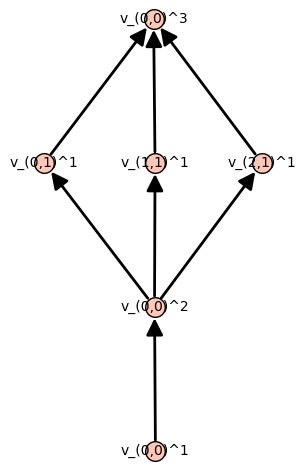

In [168]:
def getFiringPoset(countedChains):
    relations = []
    fires = countedChains[0]
    # for every pair of distinct fires
    for fireA in fires:
        for fireB in fires:
            if fireA != fireB:
                # assume fire A happens before fire B in ever chain
                AbeforeB = True
                for chain in countedChains:
                    # if in any of the chains, fire A happens second, set AbeforeB to false
                    if chain.index(fireA) > chain.index(fireB):
                        AbeforeB = False
                    # else:
                    #     print(f"{fireA} occurs before {fireB} in {chain}")
                # if there were no chains where fire A happens second, add a relation that A comes before B
                if AbeforeB == True:
                    # relations.append([str(fireA),str(fireB)])
                    firstFire = "v_(" + str(fireA[0]) + "," + str(fireA[1]) + ")^" + str(fireA[2])
                    secondFire = "v_(" + str(fireB[0]) + "," + str(fireB[1]) + ")^" + str(fireB[2])
                    relations.append([firstFire,secondFire])
    firingGraph = DiGraph(relations)
    firingPoset = Poset(firingGraph)
    return firingPoset

firingPoset = getFiringPoset(countedChains)
firingPoset.show()

# Putting it all together: choose a (k,m) in the second line, and a poset of firings will automatically be generated

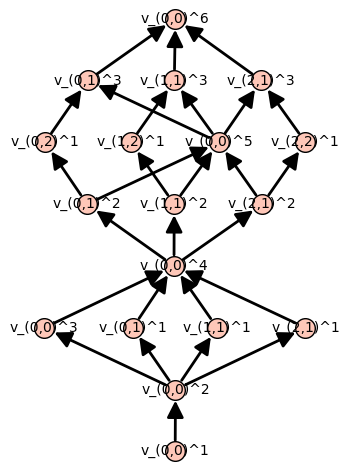

CPU times: user 45.2 s, sys: 746 ms, total: 45.9 s
Wall time: 46.5 s


In [187]:
%%time
instar = getInstar(3,3)
show_graph = False # this is for the graph of all reachable configurations with edges labeled by vertex fire
pair = getDigraphPoset(instar,show_graph)
graph = pair[0]
poset = pair[1]
chains = getChains(graph,poset)
countedChains = getCountedChains(chains)
firingPoset = getFiringPoset(countedChains)
firingPoset.show()